In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

def load_data(filename='train.csv'):
    path = os.path.join('data/', filename)
    return pd.read_csv(path)

In [3]:
train = load_data()

In [4]:
# train[categorical] = train[categorical].fillna('NA')

In [5]:
corr_matrix = train.corr()

In [6]:
corr_matrix['SalePrice'].sort_values(ascending=False)[:15]

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

<AxesSubplot:>

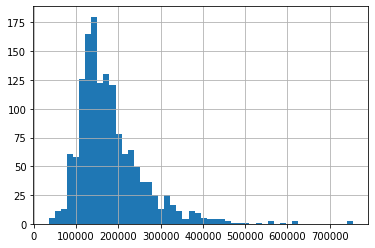

In [7]:
train['SalePrice'].hist(bins=50)

<AxesSubplot:title={'center':'SalePrice'}, xlabel='OverallQual'>

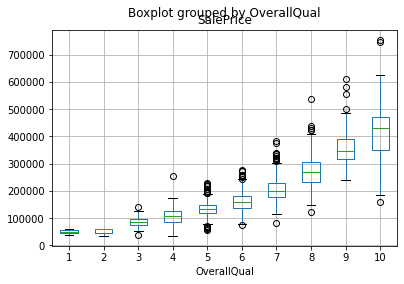

In [8]:
train.boxplot(by='OverallQual', column='SalePrice')

<AxesSubplot:>

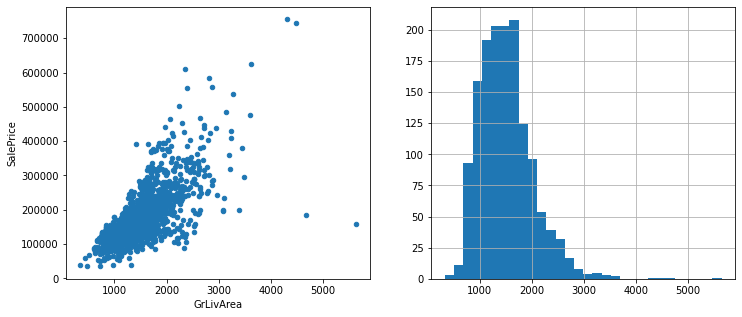

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
train.plot.scatter(x='GrLivArea', y='SalePrice', ax=axes[0])
train['GrLivArea'].hist(bins=30, ax=axes[1])

<AxesSubplot:>

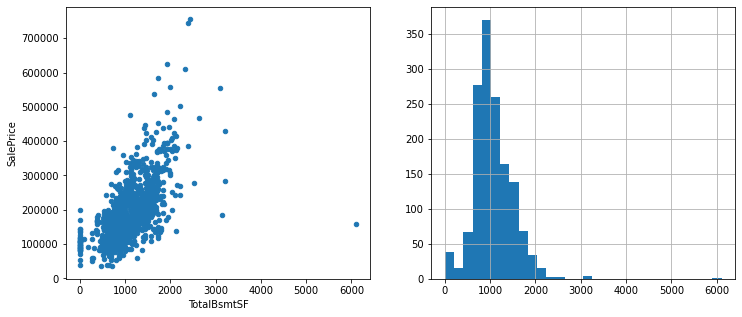

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
train.plot.scatter(x='TotalBsmtSF', y='SalePrice', ax=axes[0])
train['TotalBsmtSF'].hist(bins=30, ax=axes[1])

In [11]:
null_percent = train.isna().sum() / train.shape[0]
null_percent.loc[null_percent > 0.2]

Alley          0.937671
FireplaceQu    0.472603
PoolQC         0.995205
Fence          0.807534
MiscFeature    0.963014
dtype: float64

<AxesSubplot:>

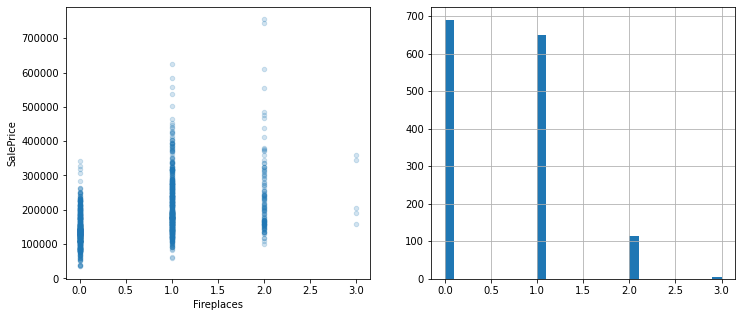

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
train.plot.scatter(x='Fireplaces', y='SalePrice', alpha=0.2, ax=axes[0])
train['Fireplaces'].hist(bins=30, ax=axes[1])

In [13]:
drop_columns = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
train.drop(columns=drop_columns, inplace=True);

In [14]:
num_nulls = train.select_dtypes(include=np.number).isna().sum()
num_nulls.loc[num_nulls > 0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

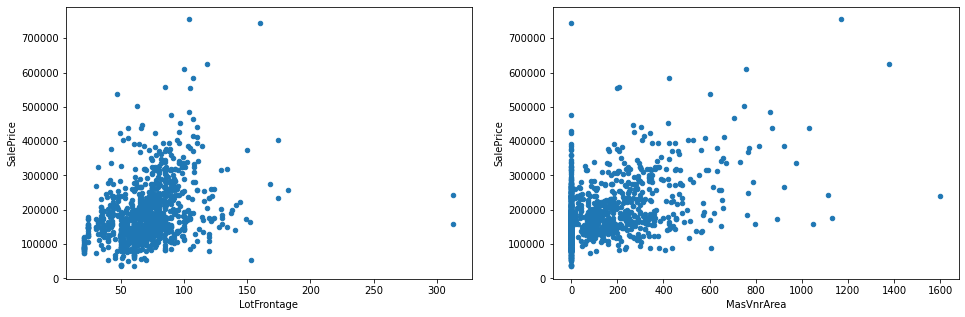

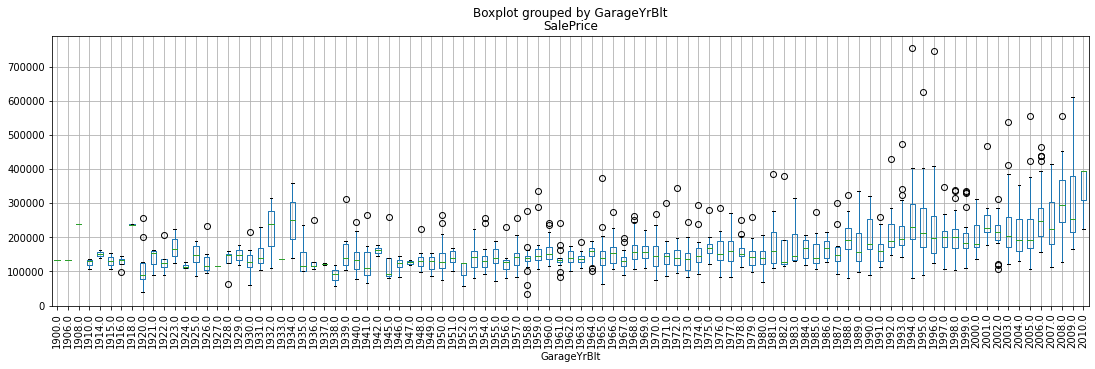

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
train.plot.scatter(x='LotFrontage', y='SalePrice', ax=axs[0])
train.plot.scatter(x='MasVnrArea', y='SalePrice', ax=axs[1])
train.boxplot(by='GarageYrBlt', column='SalePrice', figsize=(18,5))
plt.xticks(rotation=90);

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
column_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='NA'), OneHotEncoder(handle_unknown='ignore'))

col_transform = make_column_transformer(
    (num_pipe, make_column_selector(dtype_exclude='object')),
    (column_pipe, make_column_selector(dtype_include='object'))
)

In [17]:
X_raw = train.drop(columns=['SalePrice'])
X = col_transform.fit_transform(X_raw)
y = train['SalePrice']

In [18]:
test = load_data('test.csv')
X_test = test.drop(columns=drop_columns)

In [19]:
X_test_prep = col_transform.transform(X_test)

In [88]:
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import (GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor,
VotingRegressor)
from sklearn.metrics import mean_squared_error

In [30]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)

print(lin_reg.score(X, y), cross_val_score(lin_reg, X, y).mean())

0.9313921337195784 0.806322868607212


In [21]:
ridge = RidgeCV(alphas=[0.1, 0.3, 1, 3, 10, 30])
ridge.fit(X, y)

print(ridge.score(X, y), cross_val_score(ridge, X, y).mean(), ridge.alpha_)

0.8992284397638329 0.8371766507787729 10.0


In [22]:
lasso = LassoCV()
lasso.fit(X, y)

print(lasso.score(X, y), cross_val_score(lasso, X, y).mean(), lasso.alpha_)

0.9049066326772708 0.8461557423753057 155.60011430000537


In [42]:
lin_svr = LinearSVR(max_iter=10000, C=2400)
lin_svr.fit(X, y)

print(lin_svr.score(X, y), cross_val_score(lin_svr, X, y).mean())

0.8669483247226049 0.8543730951292783


In [45]:
grad_boost = GradientBoostingRegressor(learning_rate=0.2, max_features=50, subsample=0.8)
grad_boost.fit(X, y)

print(grad_boost.score(X, y), cross_val_score(grad_boost, X, y).mean())

0.9666451434428119 0.8866006416862341


In [70]:
forest = RandomForestRegressor(max_features=100, min_samples_split=3, n_jobs=-1)
forest.fit(X, y)

print(forest.score(X, y), cross_val_score(forest, X, y).mean())

0.9808895769864524 0.8705754365434191


In [75]:
extra = ExtraTreesRegressor(min_samples_split=4, n_jobs=-1)
extra.fit(X, y)

print(extra.score(X, y), cross_val_score(extra, X, y).mean())

0.998525264056266 0.8733959488757593


In [84]:
grid_ada = GridSearchCV(VotingRegressor(), {
    'learning_rate': [0.3, 0.6, 1]
}, verbose=3, n_jobs=-1)
grid_ada.fit(X, y)

print(grid_ada.score(X, y), grid_ada.best_score_, grid_ada.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  4.1min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  7.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  7.3min finished


AttributeError: 'GridSearchCV' object has no attribute 'base_params_'

In [90]:
predictions = grad_boost.predict(X_test_prep)
submission = pd.DataFrame({'Id': test.Id, 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)
submission.head()

,Id,SalePrice
0,1461,122961.904368
1,1462,162460.532104
2,1463,180967.605161
3,1464,178790.866339
4,1465,195713.837038
